# 可转债可视化分析工具

本工具提供四种可视化图表，用于辅助可转债投资决策：

1. **价格 vs. 溢价率散点图** - 识别高价高溢价的风险转债和低价低溢价的机会转债
2. **下修博弈进度图 (The Gaming Map)** - 显示处于下修计数过程中的转债分布
3. **YTM-期限-评级气泡图** - 揪出"伪高收益"陷阱
4. **溢价率与正股强弱象限图** - 寻找"强强联手"机会

In [24]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from typing import Optional
from data_loader import load_cb_data, merge_cb_data
from cb_screener import calculate_metrics

# 设置中文字体
plt.rcParams["font.sans-serif"] = [
    "Microsoft YaHei",
    "WenQuanYi Micro Hei",  # 文泉驿微米黑 (Linux常见)
    "Noto Sans CJK SC",  # Google Noto字体
    "SimHei",  # 黑体 (Windows)
    "Arial Unicode MS",  # Mac/Windows
    "DejaVu Sans",  # 默认字体
]
plt.rcParams["axes.unicode_minus"] = False  # 用来在图中正常显示负号



## 1. 价格 vs. 溢价率散点图

In [25]:
def plot_price_vs_premium(df: pd.DataFrame, save_path: Optional[str] = None):
    """价格 vs. 溢价率散点图
    
    用于识别高价高溢价的风险转债和低价低溢价的机会转债
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 过滤停牌转债
    df_plot = df[~df["是否停牌"]].copy()
    
    # 根据市值类型设置颜色
    colors = {"小市值": "red", "中市值": "orange", "大市值": "blue"}
    
    for market_type, color in colors.items():
        mask = df_plot["市值类型"] == market_type
        ax.scatter(
            df_plot[mask]["转股溢价率_数值"],
            df_plot[mask]["现价"],
            c=color,
            alpha=0.6,
            s=50,
            label=market_type
        )
    
    # 添加参考线
    ax.axhline(y=130, color='gray', linestyle='--', alpha=0.5, label='高价线(130)')
    ax.axvline(x=30, color='gray', linestyle='--', alpha=0.5, label='高溢价线(30%)')
    
    # 标注象限
    ax.text(50, 180, '双高风险区', fontsize=12, alpha=0.5, color='red')
    ax.text(5, 180, '高价低溢价', fontsize=12, alpha=0.5, color='orange')
    ax.text(50, 110, '低价高溢价', fontsize=12, alpha=0.5, color='green')
    ax.text(5, 110, '双低机会区', fontsize=12, alpha=0.5, color='green')
    
    ax.set_xlabel('转股溢价率 (%)', fontsize=12)
    ax.set_ylabel('转债价格', fontsize=12)
    ax.set_title('价格 vs. 溢价率分布图', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 2. 下修博弈进度图 (The Gaming Map)

In [26]:
def plot_adjustment_gaming_map(df: pd.DataFrame, save_path: Optional[str] = None):
    """下修博弈进度热力图 (The Gaming Map)
    
    专门辅助"博弈组"，显示处于下修计数过程中的转债分布
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 筛选有下修触发价的转债
    df_adjust = df[df["下修触发价"].notna()].copy()
    
    # 计算距离下修线的距离（%）
    df_adjust["距离下修线"] = ((df_adjust["正股价"] / df_adjust["下修触发价"]) - 1) * 100
    
    # 从下修天计数中提取已满足天数（简化处理，实际需要更复杂的解析）
    # 这里假设格式类似 "至少还需2天13/15 | 30"
    def parse_adjust_days(text):
        """解析下修天计数，提取已满足天数"""
        if pd.isna(text):
            return 0
        text_str = str(text)
        # 尝试提取 "X/Y" 格式
        import re
        match = re.search(r'(\d+)/(\d+)', text_str)
        if match:
            return int(match.group(1))
        return 0
    
    df_adjust["已满足天数"] = df_adjust["下修天计数"].apply(parse_adjust_days)
    
    # 过滤有效数据
    df_adjust = df_adjust[
        (df_adjust["距离下修线"] > -30) &
        (df_adjust["距离下修线"] < 30) &
        (df_adjust["已满足天数"] > 0)
    ]
    
    # 根据剩余规模设置气泡大小
    sizes = df_adjust["剩余规模(亿元)"] * 20
    
    # 根据评级设置颜色
    rating_colors = {
        "AAA": "darkgreen", "AA+": "green", "AA": "lightgreen",
        "AA-": "yellow", "A+": "orange", "A": "red"
    }
    colors = df_adjust["评级"].map(rating_colors).fillna("gray")
    
    ax.scatter(
        df_adjust["距离下修线"],
        df_adjust["已满足天数"],
        s=sizes,
        c=colors,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    
    # 添加参考线
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='下修触发线')
    ax.axhline(y=15, color='blue', linestyle='--', alpha=0.5, label='常见阈值(15天)')
    
    # 标注关键区域
    ax.text(-25, 13, '远离下修线', fontsize=11, alpha=0.6)
    ax.text(-5, 13, '接近触发', fontsize=11, alpha=0.6, color='red')
    ax.text(5, 13, '已突破', fontsize=11, alpha=0.6, color='green')
    
    ax.set_xlabel('距离下修线距离 (%)', fontsize=12)
    ax.set_ylabel('已满足天数', fontsize=12)
    ax.set_title('下修博弈进度图 (The Gaming Map)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 添加说明文字
    ax.text(0.02, 0.98, f'共 {len(df_adjust)} 只转债处于下修博弈中',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 3. YTM-期限-评级气泡图

In [27]:
def plot_ytm_duration_bubble(df: pd.DataFrame, save_path: Optional[str] = None):
    """YTM-期限-评级气泡图 (Credit & Time Analysis)
    
    专门辅助"防御组"，揪出"伪高收益"陷阱
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 过滤有效数据（排除停牌、到期收益为"增强"等）
    df_plot = df[
        (~df["是否停牌"]) &
        (df["剩余年限_数值"] > 0) &
        (df["到期收益_数值"] != 0)
    ].copy()
    
    # 根据评级设置颜色
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB"]
    rating_colors = {
        "AAA": "darkgreen", "AA+": "green", "AA": "lightgreen",
        "AA-": "yellow", "A+": "orange", "A": "red", "A-": "darkred",
        "BBB+": "purple", "BBB": "indigo"
    }
    
    for rating in rating_order:
        mask = df_plot["评级"] == rating
        if mask.sum() > 0:
            ax.scatter(
                df_plot[mask]["剩余年限_数值"],
                df_plot[mask]["到期收益_数值"],
                s=df_plot[mask]["剩余规模(亿元)"] * 20,
                c=rating_colors.get(rating, "gray"),
                alpha=0.6,
                label=rating,
                edgecolors='black',
                linewidth=0.5
            )
    
    # 添加参考线
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='保本线')
    ax.axhline(y=5, color='green', linestyle='--', alpha=0.5, label='合理收益线(5%)')
    
    # 标注风险区域
    ax.fill_between([0, 5], -50, 0, alpha=0.1, color='red', label='负收益风险区')
    ax.fill_between([0, 0.5], 0, 50, alpha=0.1, color='yellow', label='临期低收益区')
    
    ax.set_xlabel('剩余期限 (年)', fontsize=12)
    ax.set_ylabel('到期税前收益率 (%)', fontsize=12)
    ax.set_title('YTM-期限-评级气泡图 (Credit & Time Analysis)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # 设置合理的坐标范围
    ax.set_xlim(-0.2, max(df_plot["剩余年限_数值"].max() + 0.5, 5))
    ax.set_ylim(df_plot["到期收益_数值"].min() - 5,
                min(df_plot["到期收益_数值"].max() + 5, 30))
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 4. 溢价率与正股强弱象限图

In [28]:
def plot_premium_momentum_quadrant(df: pd.DataFrame, save_path: Optional[str] = None):
    """溢价率与正股强弱象限图 (Momentum Analysis)
    
    专门辅助"进攻组"，寻找"强强联手"
    注意：当前数据中没有正股近20日涨跌幅，使用正股当日涨跌作为替代
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 过滤停牌转债
    df_plot = df[~df["是否停牌"]].copy()
    
    # 解析正股涨跌幅
    def parse_change(val):
        val_str = str(val).strip()
        if val_str in ["-", "nan", "0.00%"]:
            return 0.0
        try:
            return float(val_str.rstrip("%"))
        except ValueError:
            return 0.0
    
    df_plot["正股涨跌_数值"] = df_plot["正股涨跌"].apply(parse_change)
    
    # 根据市值类型设置颜色
    colors = {"小市值": "red", "中市值": "orange", "大市值": "blue"}
    
    for market_type, color in colors.items():
        mask = df_plot["市值类型"] == market_type
        ax.scatter(
            df_plot[mask]["转股溢价率_数值"],
            df_plot[mask]["正股涨跌_数值"],
            c=color,
            alpha=0.6,
            s=50,
            label=market_type
        )
    
    # 添加象限分割线
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=20, color='black', linestyle='-', linewidth=1)
    
    # 标注四个象限
    ax.text(5, 8, '强强联手\n(低溢价+强势)', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            ha='center')
    ax.text(40, 8, '正股强势\n但溢价高', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            ha='center')
    ax.text(5, -8, '低溢价\n但正股弱', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            ha='center')
    ax.text(40, -8, '双弱回避区\n(高溢价+弱势)', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
            ha='center')
    
    ax.set_xlabel('转股溢价率 (%)', fontsize=12)
    ax.set_ylabel('正股涨跌幅 (%)', fontsize=12)
    ax.set_title('溢价率与正股强弱象限图 (Momentum Analysis)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 添加说明
    ax.text(0.02, 0.02, '注：当前使用正股当日涨跌幅，理想情况应使用近20日涨跌幅',
            transform=ax.transAxes, fontsize=9, style='italic',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 加载数据并生成所有图表

In [29]:
# 加载数据
print("正在加载数据...")
data = load_cb_data(date="2026-01-09")
df = merge_cb_data(data)
df = calculate_metrics(df)

print(f"数据加载完成，共 {len(df)} 条转债")
print(f"其中停牌: {df['是否停牌'].sum()} 条")

正在加载数据...
✓ 加载 data 表: 381 行
✓ 加载 redeem 表: 387 行
✓ 加载 adjust 表: 388 行
✓ 加载 put 表: 387 行
数据加载完成，共 381 条转债
其中停牌: 2 条


/home/ubuntu/py-fin/data_loader.py:39: ParserWarning: Skipping line 306: expected 15 fields, saw 16

  df = pd.read_csv(filepath, encoding='utf-8-sig', on_bad_lines='warn')
/home/ubuntu/py-fin/data_loader.py:39: ParserWarning: Skipping line 181: expected 15 fields, saw 16

  df = pd.read_csv(filepath, encoding='utf-8-sig', on_bad_lines='warn')


生成图表 1/4: 价格 vs. 溢价率散点图...


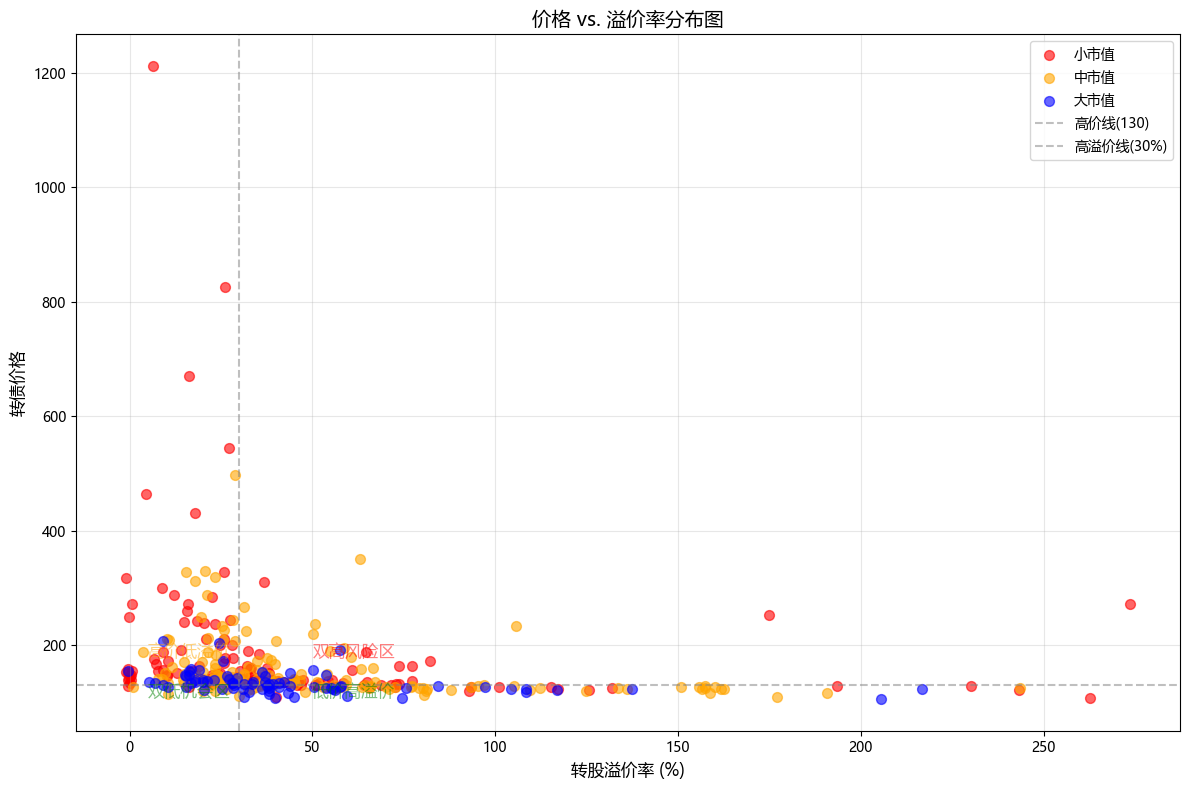

In [30]:
# 生成图表 1: 价格 vs. 溢价率散点图
print("生成图表 1/4: 价格 vs. 溢价率散点图...")
plot_price_vs_premium(df)

生成图表 2/4: 下修博弈进度图...


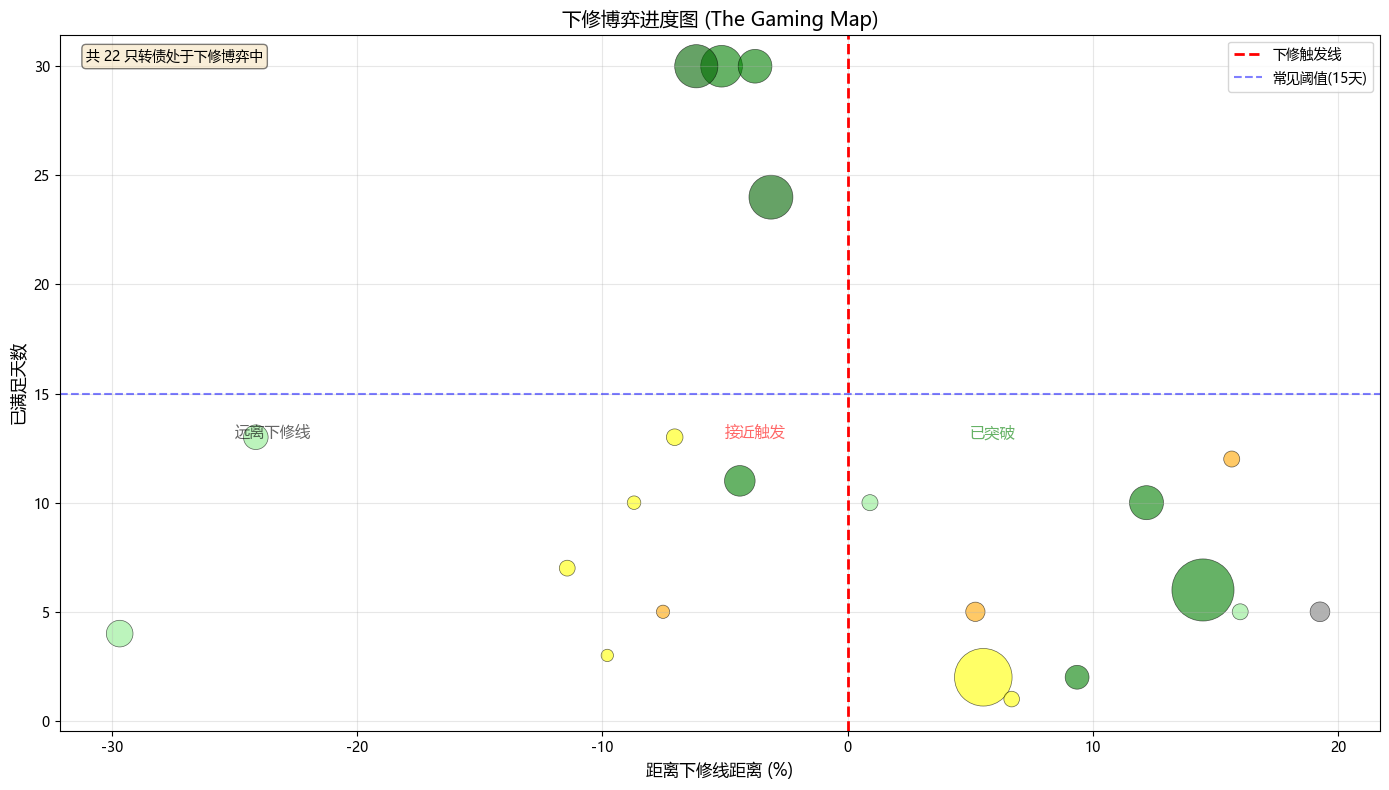

In [31]:
# 生成图表 2: 下修博弈进度图
print("生成图表 2/4: 下修博弈进度图...")
plot_adjustment_gaming_map(df)

生成图表 3/4: YTM-期限-评级气泡图...


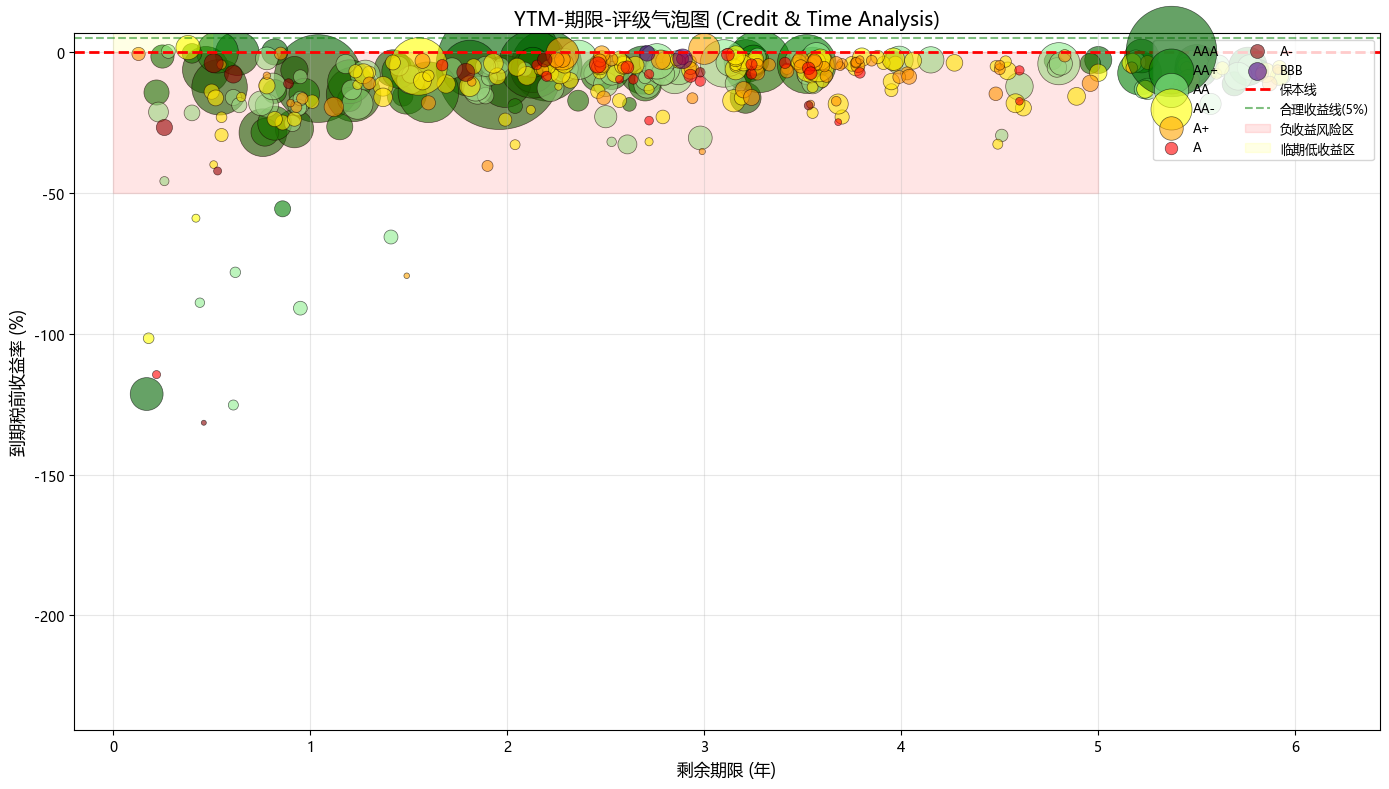

In [32]:
# 生成图表 3: YTM-期限-评级气泡图
print("生成图表 3/4: YTM-期限-评级气泡图...")
plot_ytm_duration_bubble(df)

生成图表 4/4: 溢价率与正股强弱象限图...


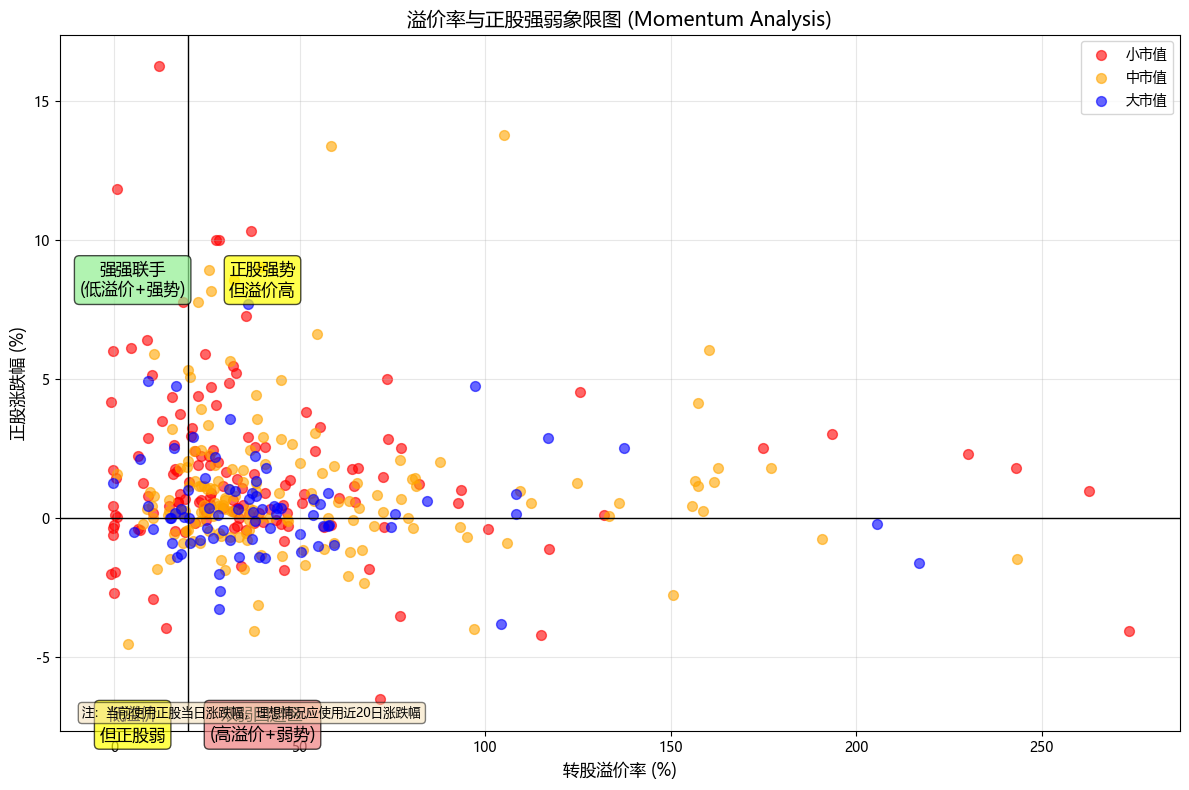

In [33]:
# 生成图表 4: 溢价率与正股强弱象限图
print("生成图表 4/4: 溢价率与正股强弱象限图...")
plot_premium_momentum_quadrant(df)

## 保存所有图表到文件

如果需要保存图表，可以运行下面的代码：

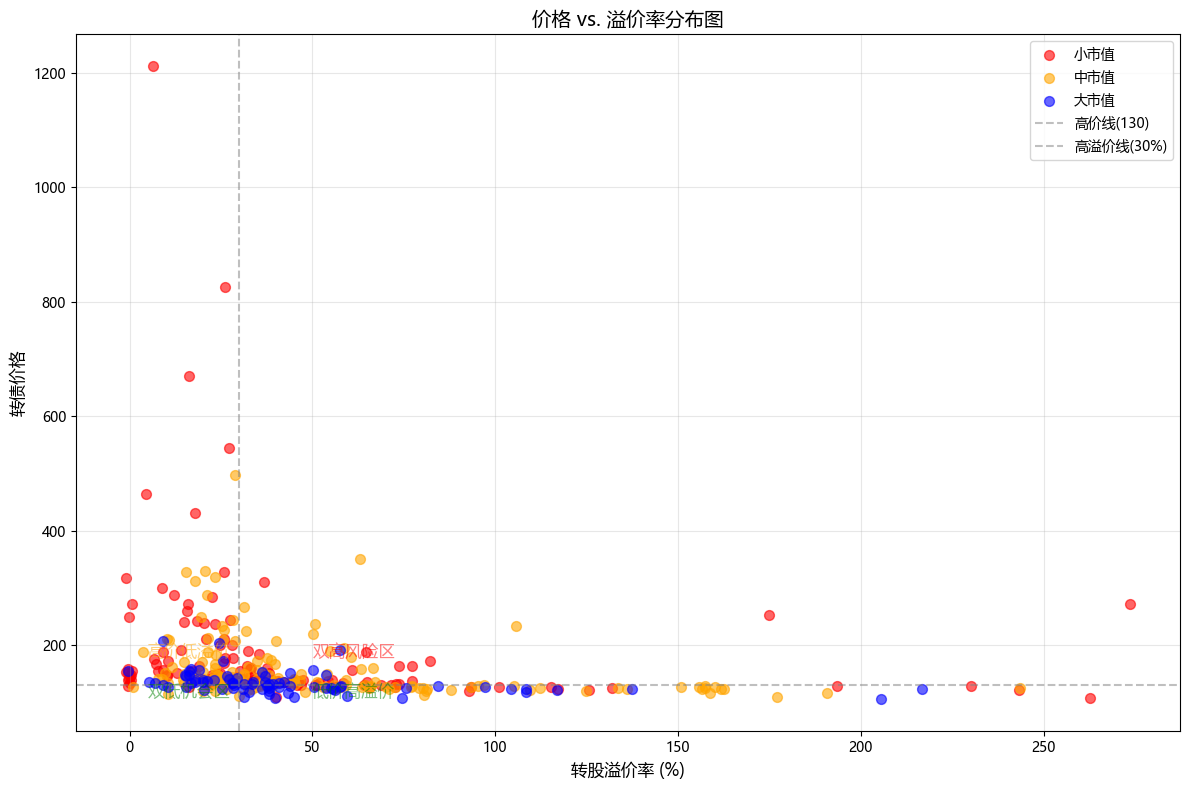

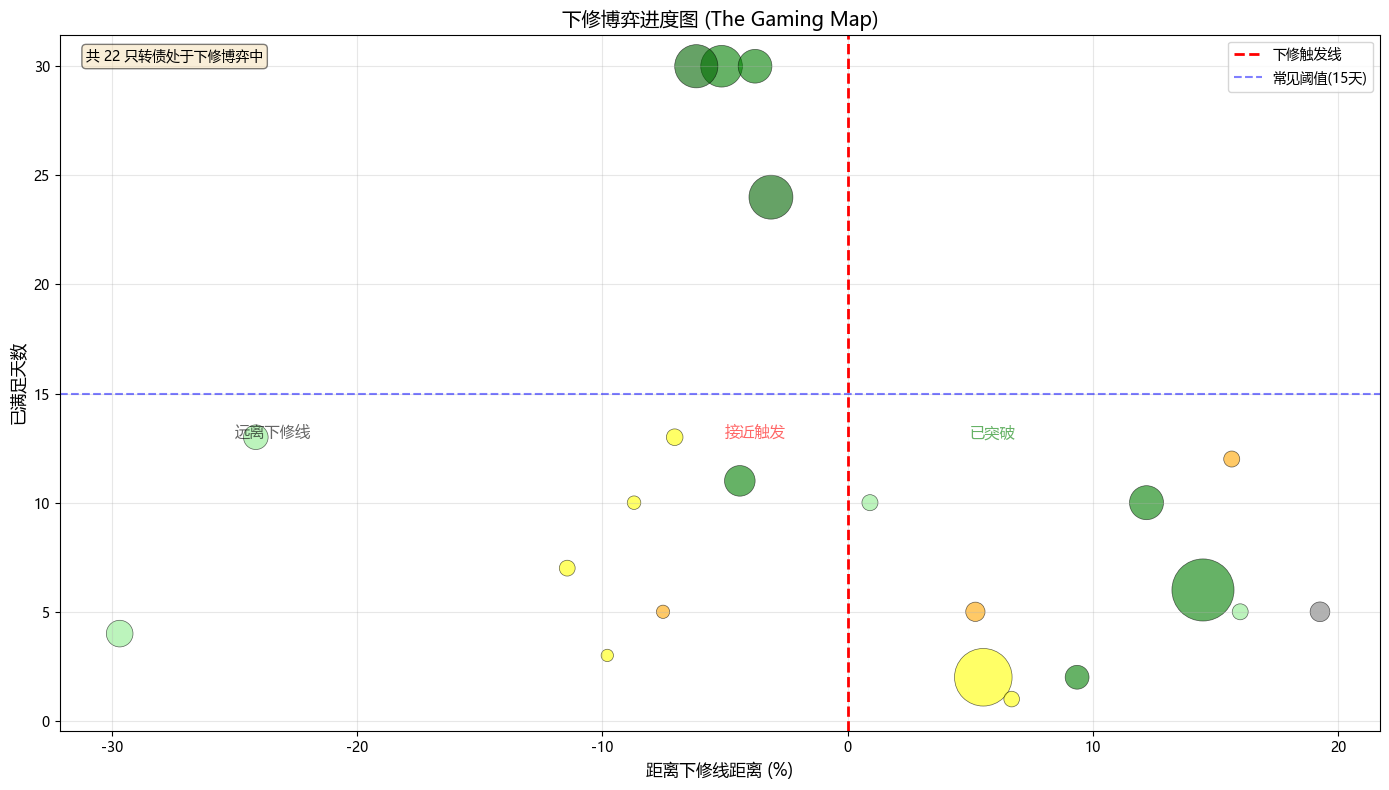

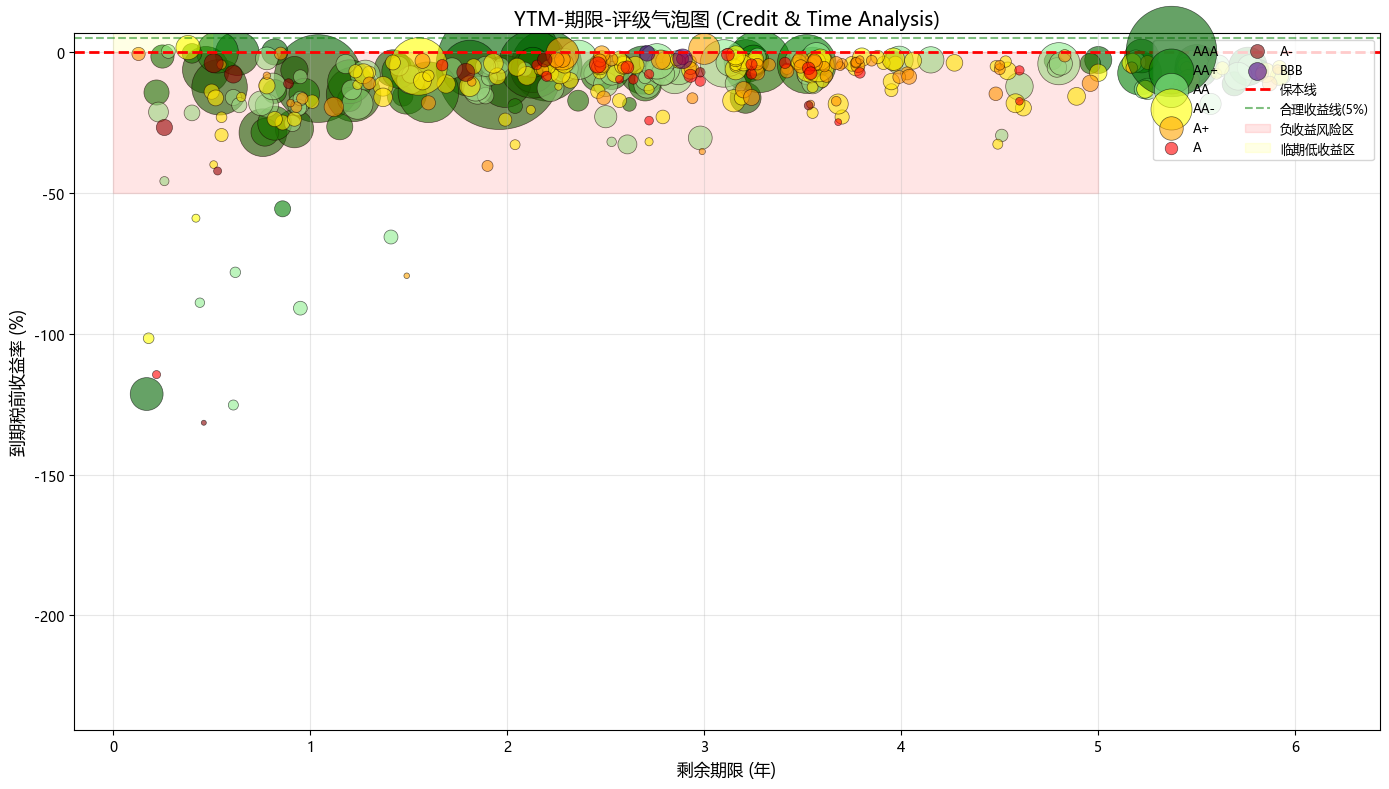

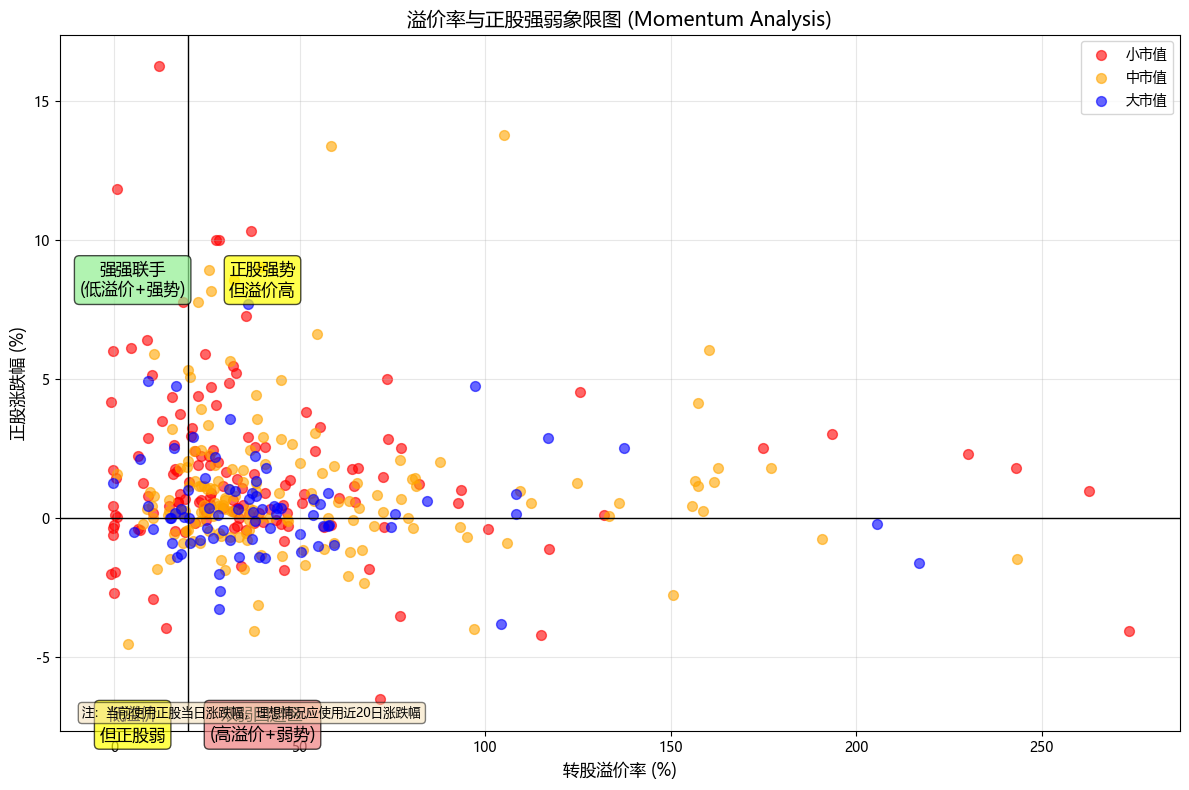

所有图表已保存到 charts/ 目录


In [34]:
import os

# 创建输出目录
output_dir = "charts"
os.makedirs(output_dir, exist_ok=True)

# 保存所有图表
plot_price_vs_premium(df, f"{output_dir}/01_price_vs_premium.png")
plot_adjustment_gaming_map(df, f"{output_dir}/02_adjustment_gaming_map.png")
plot_ytm_duration_bubble(df, f"{output_dir}/03_ytm_duration_bubble.png")
plot_premium_momentum_quadrant(df, f"{output_dir}/04_premium_momentum_quadrant.png")

print(f"所有图表已保存到 {output_dir}/ 目录")